In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import ConcatDataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
train_food_path = "/kaggle/input/project-data/Project Data/Food/Train"
train_fruit_path = "/kaggle/input/project-data/Project Data/Fruit/Train"
val_food_path = "/kaggle/input/project-data/Project Data/Food/Validation"
val_fruit_path = "/kaggle/input/project-data/Project Data/Fruit/Validation"

In [4]:
fruits_list = os.listdir(train_fruit_path)
foods_list = os.listdir(train_food_path)
for fruit in fruits_list:
    if fruit in foods_list:
        print(f"Warning: Conflict found: {fruit} is in both folders.")

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
def ignore_masks(path):
    return "mask" not in path.lower()

In [7]:
train_food_dataset = datasets.ImageFolder(
    root=train_food_path,
    transform=data_transforms['train'],
    target_transform=lambda y: 0
)
train_fruit_dataset = datasets.ImageFolder(
    root=train_fruit_path,
    transform=data_transforms['train'],
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks
)

full_train_dataset = ConcatDataset([train_food_dataset, train_fruit_dataset])

print(f"Total Training Images: {len(full_train_dataset)}")

train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=3
)

Total Training Images: 4297


In [8]:
val_food_dataset = datasets.ImageFolder(
    root=val_food_path,
    transform=data_transforms['val'],
    target_transform=lambda y: 0
)

val_fruit_dataset = datasets.ImageFolder(
    root=val_fruit_path,
    transform=data_transforms['val'],
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks
)
full_val_dataset = ConcatDataset([val_food_dataset, val_fruit_dataset])

print(f"Total Validation Images: {len(full_val_dataset)}")

val_loader = DataLoader(
    full_val_dataset,
    batch_size=32,
    shuffle=True
)

Total Validation Images: 411


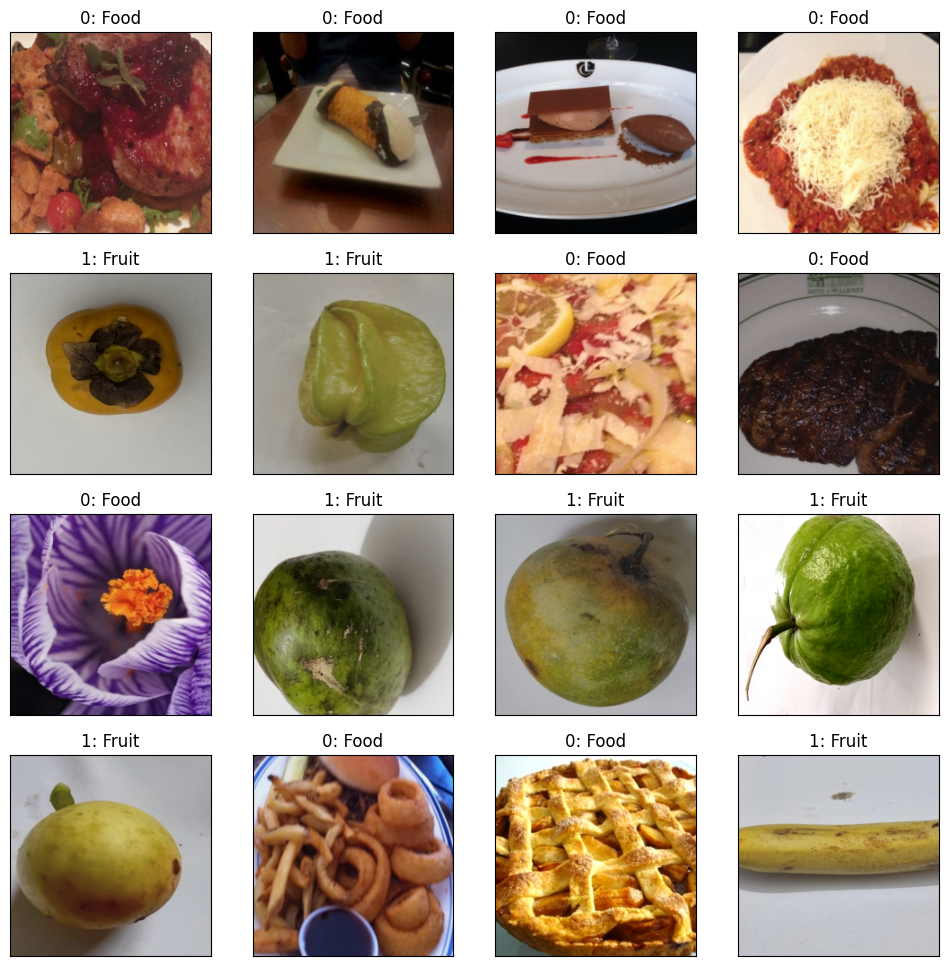

In [9]:
import numpy as np
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_names = {0: 'Food', 1: 'Fruit'}

fig = plt.figure(figsize=(12, 12))
for i in range(min(16, len(images))):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    imshow(images[i], title=f"{labels[i].item()}: {class_names[labels[i].item()]}")
plt.show()

In [10]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, 2)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s]


In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [12]:
num_epochs = 10

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    # --------Training --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    exp_lr_scheduler.step()
    train_loss = running_loss / total
    train_acc = correct / total

    current_lr = optimizer.param_groups[0]['lr']

    # -------- Validation --------
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels) 
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 50)


Epoch [1/10]
Train Loss: 0.1266 | Train Acc: 0.9679
Val   Loss: 0.0048 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.0083 | Train Acc: 0.9986
Val   Loss: 0.0019 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.0038 | Train Acc: 0.9988
Val   Loss: 0.0008 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.0028 | Train Acc: 0.9993
Val   Loss: 0.0008 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.0032 | Train Acc: 0.9984
Val   Loss: 0.0007 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.0023 | Train Acc: 0.9993
Val   Loss: 0.0012 | Val   Acc: 1.0000
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.0015 | Train Acc: 0.9998
Val   Loss: 0.0008 | Val   Acc: 1.0000
--------------------------------------------------
Epoch 

In [13]:
torch.save(model.state_dict(), "model_A_food_vs_fruit.pth")
print("Model saved as model_A_food_vs_fruit.pth")

Model saved as model_A_food_vs_fruit.pth


In [14]:
from PIL import Image

def predict_image(path, model):
    model.eval()

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

    try:
        img = Image.open(path).convert("RGB")
        img = test_transforms(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, pred = torch.max(probabilities, 1)

        label = "Food" if pred.item() == 0 else "Fruit"
        conf_percent = confidence.item() * 100
        return f"Prediction: {label} (Confidence: {conf_percent:.2f}%)"

    except Exception as e:
        return f"Error processing image {path}: {str(e)}"

In [15]:
# food
test_image_1 = "/kaggle/input/test-data/food/food.jpg"

# fruit
test_image_2 = "/kaggle/input/test-data/fruit/fruit.jpeg"

print(predict_image(test_image_1, model))
print(predict_image(test_image_2, model))


Prediction: Food (Confidence: 99.96%)
Prediction: Fruit (Confidence: 99.81%)


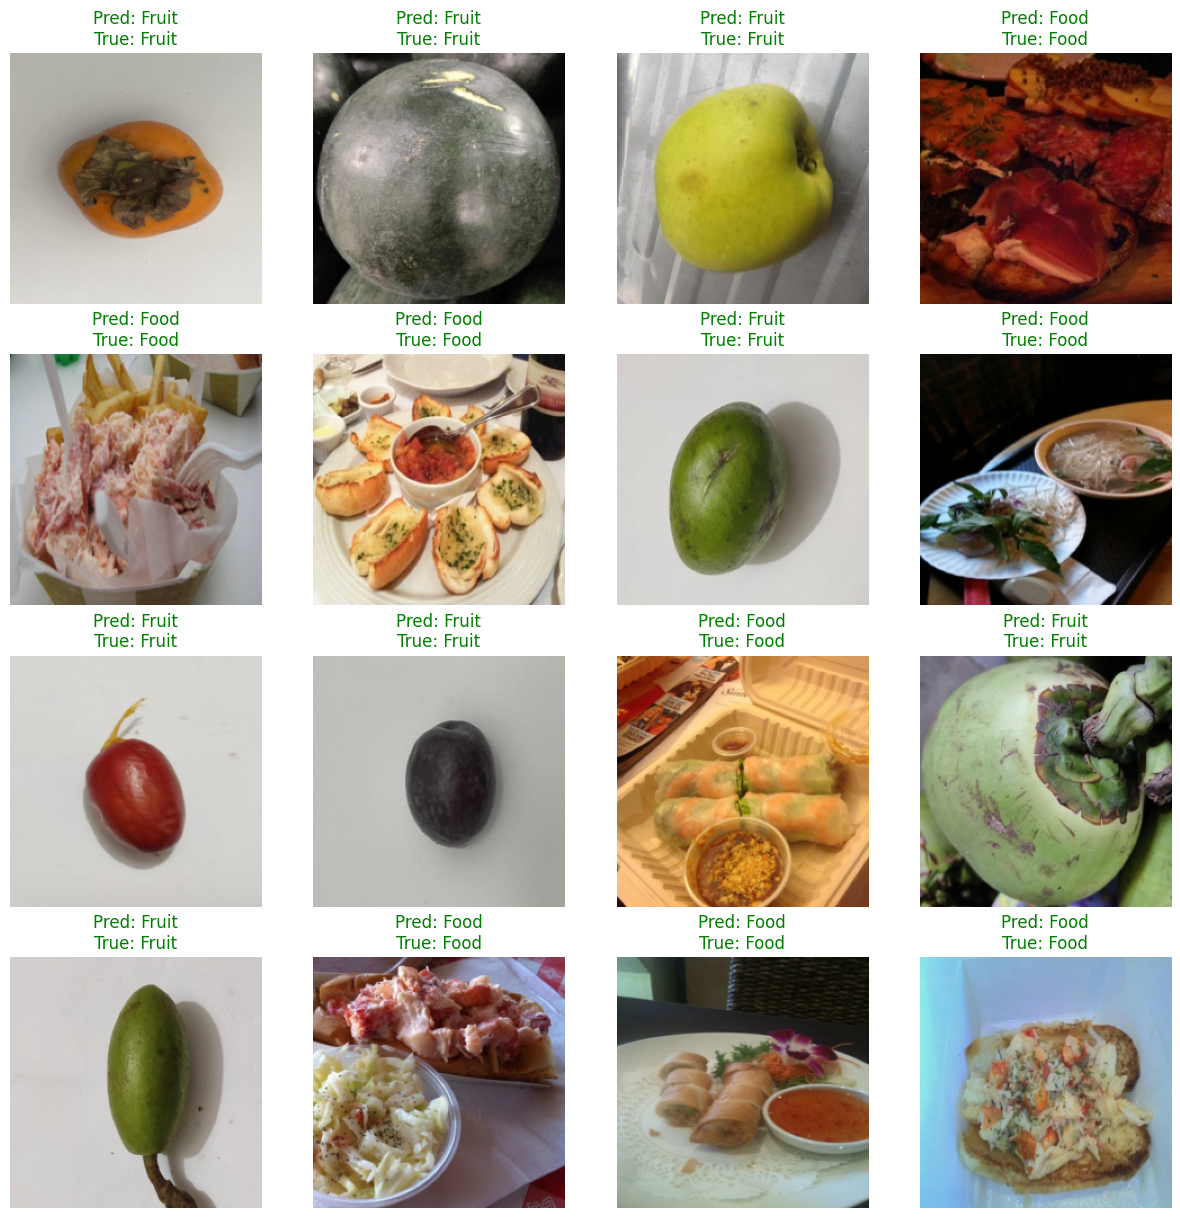

In [16]:
def visualize_validation_predictions(model, loader, num_images=16):
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15)) 
    
    norm_mean = np.array([0.485, 0.456, 0.406])
    norm_std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(4, 4, images_so_far)
                ax.axis('off')
                
                pred_label = class_names[preds[j].item()]
                true_label = class_names[labels[j].item()]
                
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
                
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = norm_std * img + norm_mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.show() 
                    return
        model.train(mode=was_training)

visualize_validation_predictions(model, val_loader)

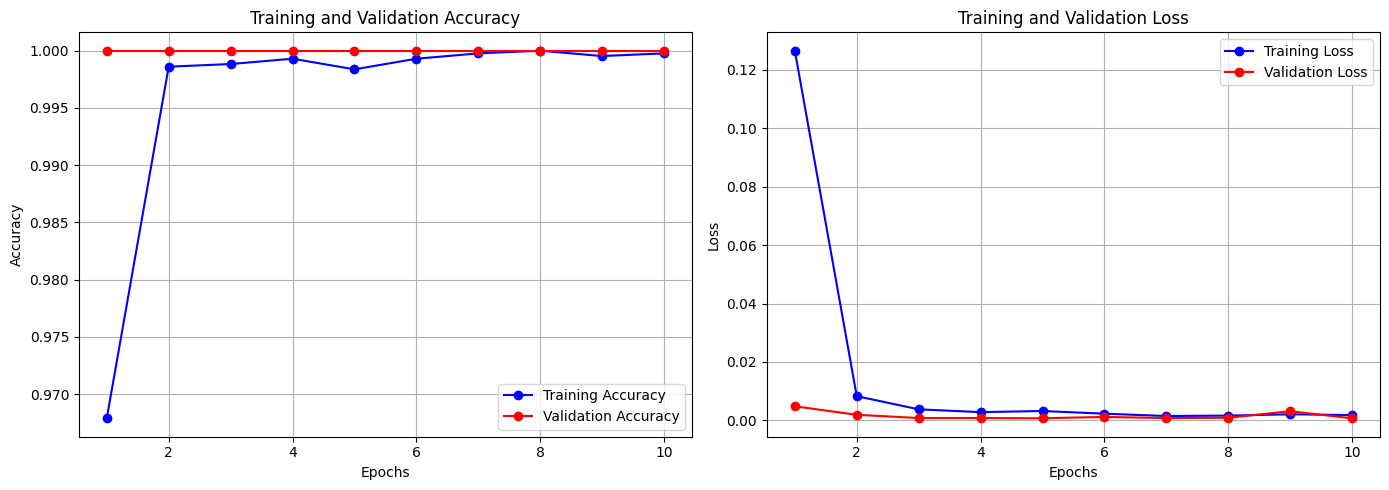

In [17]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    if len(acc) == 0:
        print("Error: History is empty! Make sure you ran the training loop.")
        return

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_history(history)

# TEST SCRIPT

In [18]:
# import torch
# import torch.nn as nn
# from torchvision import models, transforms
# from PIL import Image
# import os


# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]

# def load_model(model_path):
   
#     model = models.efficientnet_b0(weights=None) 
    
#     model.classifier = nn.Sequential(
#         nn.Dropout(p=0.5),
#         nn.Linear(num_features, 512),
#         nn.ReLU(),
#         nn.Dropout(p=0.4),
#         nn.Linear(512, 2)
#     )
    
#     if torch.cuda.is_available():
#         state_dict = torch.load(model_path)
#     else:
#         state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    
#     model.load_state_dict(state_dict)
#     model = model.to(device)
#     model.eval()
#     return model

# def predict_image(path, model):
#     test_transforms = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(norm_mean, norm_std)
#     ])
    
#     try:
#         img = Image.open(path).convert("RGB")
#         img_tensor = test_transforms(img).unsqueeze(0).to(device)
        
#         with torch.no_grad():
#             output = model(img_tensor)
#             probabilities = torch.nn.functional.softmax(output, dim=1)
#             confidence, pred = torch.max(probabilities, 1)
            
#         label = "Food" if pred.item() == 0 else "Fruit"
#         return f"Prediction: {label}"
        
#     except Exception as e:
#         return f"Error processing image {path}: {str(e)}"


# model_path = "model_A_food_vs_fruit.pth" 
# test_image = "/kaggle/input/test-data/fruit/fruit.jpeg"          

# if os.path.exists(model_path):
    
#     loaded_model = load_model(model_path)
    
#     print(predict_image(test_image, loaded_model))
  
# else:
#     print("Model file not found!")